# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!pip install Pillow
!pip install scipy==1.2.1

     |████████████████████████████████| 24.8MB 135kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
##tf.set_random_seed(30) #This Tensorflow is applicable for scipy 1.1.0 version
tf.random.set_seed(30)
print(tf.__version__)

2.4.1


In [4]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [6]:
from google.colab import drive
drive.mount('/content/google_drive')
project_folder = ('/content/Project_data')

Mounted at /content/google_drive


In [7]:
# importing shutil module  
import shutil 

# Full path of the archive file 
Project_data = "/content/google_drive/MyDrive/Project_data.zip"

# Unpack the archived file  
shutil.unpack_archive(Project_data)


##### Plotting

In [8]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx` and normalization such that you get high accuracy.

In [9]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    # shifted = cv2.warpAffine(image_resized, 
                    # np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    # (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

  
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Type-1-CONV3D- with 5 different-Models:

In [28]:
class ModelConv3D1(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### Experimenting with Image resolution, number of frames to use and batch_size

##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

**Model-1- CNN3D:**
- Image Height-160, Image-width-160
- Frames to sample-30,
- batch size-40
- epochs -1

In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

In [13]:
conv_3d1.train_model(conv_3d1_model)

17/17 [==============================] - 101s 6s/step - loss: 1.9619 - categorical_accuracy: 0.3195 - val_loss: 2.5838 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-1505_26_25.135618/model-00001-1.63758-0.39065-2.58377-0.16000.h5


In [14]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


**Sample Cropping**:

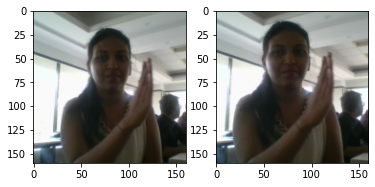

In [23]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3, num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

**Model 2-CNN3D:**
- image_height=160,
- image_width=160
- frames_to_sample=16,
- batch_size=30,
- num_epochs=3

In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 57s 2s/step - loss: 1.9468 - categorical_accuracy: 0.3737 - val_loss: 3.1800 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-1505_45_48.147174/model-00001-1.69550-0.41478-3.17999-0.16000.h5
Epoch 2/3
23/23 [==============================] - 48s 2s/step - loss: 1.1927 - categorical_accuracy: 0.5386 - val_loss: 6.0623 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-1505_45_48.147174/model-00002-1.11625-0.55958-6.06232-0.23000.h5
Epoch 3/3
23/23 [==============================] - 49s 2s/step - loss: 0.9148 - categorical_accuracy: 0.6578 - val_loss: 7.6354 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2021-02-1505_45_48.147174/model-00003-0.92554-0.64103-7.63540-0.16000.h5


**Model 3-CNN3D:**
- image_height=100,
- image_width=100
- frames_to_sample=30,
- batch_size=30,
- num_epochs=2


In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 84s 4s/step - loss: 1.7637 - categorical_accuracy: 0.3503 - val_loss: 1.9257 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-1505_57_02.539456/model-00001-1.59052-0.39517-1.92570-0.16000.h5
Epoch 2/2
23/23 [==============================] - 79s 4s/step - loss: 1.0943 - categorical_accuracy: 0.5762 - val_loss: 2.6685 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2021-02-1505_57_02.539456/model-00002-1.11864-0.57164-2.66847-0.18000.h5


**Model 4-CNN3D:**
- image_height=100,
- image_width=100
- frames_to_sample=30,
- batch_size=60,
- num_epochs=2


In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 84s 7s/step - loss: 2.1142 - categorical_accuracy: 0.2938 - val_loss: 1.9000 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-02-1506_08_14.892132/model-00001-1.81982-0.35897-1.89995-0.21000.h5
Epoch 2/2
12/12 [==============================] - 86s 8s/step - loss: 1.3048 - categorical_accuracy: 0.4911 - val_loss: 3.8390 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2021-02-1506_08_14.892132/model-00002-1.30516-0.49925-3.83896-0.24000.h5


**Model 5-CNN3D:**
- image_height=100,
- image_width=100
- frames_to_sample=16,
- batch_size=60,
- num_epochs=2


In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 50s 4s/step - loss: 1.8093 - categorical_accuracy: 0.3253 - val_loss: 1.5353 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2021-02-1506_11_46.115725/model-00001-1.59675-0.39216-1.53528-0.32000.h5
Epoch 2/2
12/12 [==============================] - 42s 4s/step - loss: 1.0997 - categorical_accuracy: 0.5742 - val_loss: 2.0025 - val_categorical_accuracy: 0.1300

Epoch 00002: saving model to model_init_2021-02-1506_11_46.115725/model-00002-1.13994-0.55807-2.00252-0.13000.h5


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Type-2-Conv3D- 2 different models:
- without DataAugmentation Model
- with DataAugmentation Model

In [10]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Model 6- CONV3D** 
- Base Model- No Data Augmentation 
- (3,3,3) filter
- Batch Size 40 
- Epoch 15
- image_height-160,image_width-160
- frames_to_sample-20

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 80, 80, 32)    1

In [14]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 78s 4s/step - loss: 1.9242 - categorical_accuracy: 0.2706 - val_loss: 1.6145 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2021-02-1506_32_15.571082/model-00001-1.69602-0.32881-1.61446-0.24000.h5
Epoch 2/15
17/17 [==============================] - 63s 4s/step - loss: 1.2173 - categorical_accuracy: 0.5283 - val_loss: 8.3230 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2021-02-1506_32_15.571082/model-00002-1.13474-0.56561-8.32302-0.15000.h5
Epoch 3/15
17/17 [==============================] - 64s 4s/step - loss: 0.8377 - categorical_accuracy: 0.6564 - val_loss: 5.8182 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-02-1506_32_15.571082/model-00003-0.81177-0.66968-5.81820-0.20000.h5
Epoch 4/15
17/17 [==============================] - 63s 4s/step - loss: 0.6583 - categorical_accuracy: 0.7341 - val_loss: 5.9565 - val_categoric

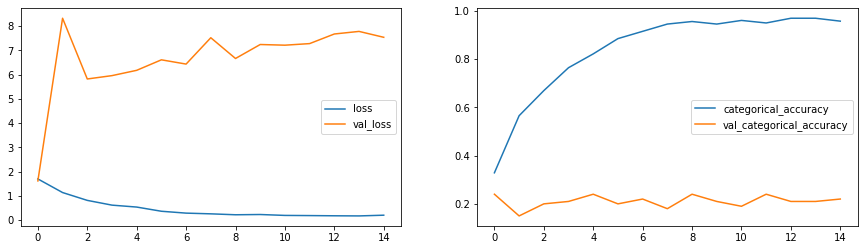

In [15]:
plot(history_model1)

Model is clearly overfitting. So we need to do data augmentation

**Model 7-Conv3D:**
- Data Augmentation, 
- (3,3,3) filter 
- 160x160 image resolution
- frames to sample-20
- batch size-20
- epochs-25
- dense neurons-256
- dropout-0.5

In [16]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 80, 80, 32)   

In [17]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 121s 4s/step - loss: 2.1090 - categorical_accuracy: 0.3303 - val_loss: 2.3954 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-1506_49_20.968347/model-00001-1.92534-0.37858-2.39542-0.16000.h5
Epoch 2/25
34/34 [==============================] - 113s 3s/step - loss: 1.5575 - categorical_accuracy: 0.4888 - val_loss: 3.4193 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2021-02-1506_49_20.968347/model-00002-1.54927-0.48944-3.41934-0.15000.h5
Epoch 3/25
34/34 [==============================] - 113s 3s/step - loss: 1.1930 - categorical_accuracy: 0.5672 - val_loss: 3.7884 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2021-02-1506_49_20.968347/model-00003-1.24394-0.55505-3.78841-0.22000.h5
Epoch 4/25
34/34 [==============================] - 114s 3s/step - loss: 1.0367 - categorical_accuracy: 0.5997 - val_loss: 5.8701 - val_categ

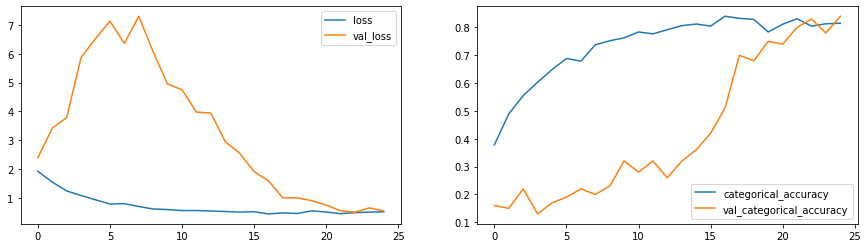

In [18]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 84% and training accuracy of 81%. 

# Type-3-Models- CNN - LSTM Models

In [19]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Model 8-Conv2D-LSTM:** 
- 120X120 image resolution
- frames to sample-18
- batch size-20
- epochs-20
- dense neurons-128
- dropout-0.25
- lstm cells-128

In [20]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)   

In [21]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 93s 3s/step - loss: 1.5241 - categorical_accuracy: 0.3181 - val_loss: 1.6714 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2021-02-1507_55_57.336111/model-00001-1.41922-0.37934-1.67141-0.22000.h5
Epoch 2/20
34/34 [==============================] - 89s 3s/step - loss: 1.1692 - categorical_accuracy: 0.5130 - val_loss: 1.7006 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-1507_55_57.336111/model-00002-1.12171-0.53922-1.70062-0.23000.h5
Epoch 3/20
34/34 [==============================] - 89s 3s/step - loss: 1.0055 - categorical_accuracy: 0.6027 - val_loss: 2.1315 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2021-02-1507_55_57.336111/model-00003-1.00956-0.59351-2.13149-0.30000.h5
Epoch 4/20
34/34 [==============================] - 88s 3s/step - loss: 0.9224 - categorical_accuracy: 0.6287 - val_loss: 2.7741 - val_categoric

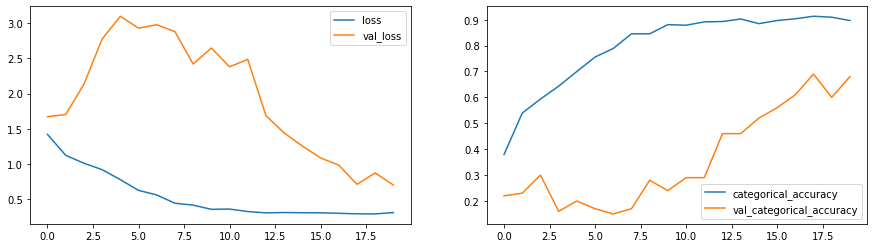

In [22]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 68%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [10]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Type-4 Conv3D

**Model 9-Conv3D:** 
- Data Augmentation
- (3,3,3) filter size
- 160X160 image resolution
- frames to sample-20
- batch size-20
- epochs-30
- dense neurons-256
- dropout-0.50


In [24]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 80, 80, 32)   

In [26]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 119s 4s/step - loss: 2.4440 - categorical_accuracy: 0.2863 - val_loss: 2.3721 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-1509_18_49.715691/model-00001-2.16905-0.33937-2.37208-0.16000.h5
Epoch 2/30
34/34 [==============================] - 118s 4s/step - loss: 1.4793 - categorical_accuracy: 0.4911 - val_loss: 2.5595 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model_init_2021-02-1509_18_49.715691/model-00002-1.48950-0.49095-2.55948-0.19000.h5
Epoch 3/30
34/34 [==============================] - 118s 4s/step - loss: 1.3716 - categorical_accuracy: 0.5153 - val_loss: 2.7951 - val_categorical_accuracy: 0.1700

Epoch 00003: saving model to model_init_2021-02-1509_18_49.715691/model-00003-1.35061-0.51961-2.79506-0.17000.h5
Epoch 4/30
34/34 [==============================] - 118s 4s/step - loss: 1.0995 - categorical_accuracy: 0.6272 - val_loss: 3.9122 - val_categ

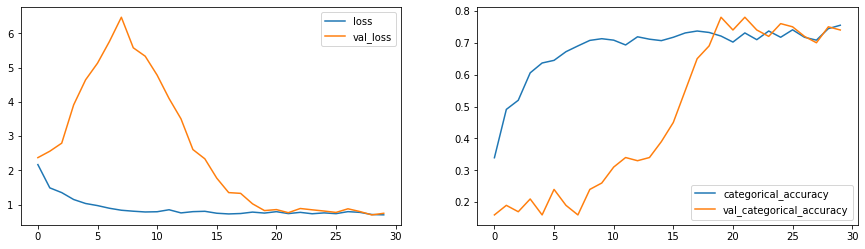

In [29]:
plot(history_model10)

# Type-5 Conv3D:

In [27]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same', input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Model 10-Conv3D:** 
- Data Augmentation
- (2,2,2) filter size
- 120X120 image resolution
- frames to sample-16
- batch size-30
- epochs-30
- dense neurons-256
- dropout-0.50


In [28]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_13 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 60, 60, 32)    

In [30]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 88s 4s/step - loss: 2.5002 - categorical_accuracy: 0.2363 - val_loss: 1.7992 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-1510_22_26.827201/model-00001-2.31455-0.28281-1.79918-0.16000.h5
Epoch 2/30
23/23 [==============================] - 82s 4s/step - loss: 1.7170 - categorical_accuracy: 0.4244 - val_loss: 2.5623 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2021-02-1510_22_26.827201/model-00002-1.61895-0.44193-2.56234-0.15000.h5
Epoch 3/30
23/23 [==============================] - 83s 4s/step - loss: 1.4136 - categorical_accuracy: 0.4836 - val_loss: 3.7914 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to model_init_2021-02-1510_22_26.827201/model-00003-1.35568-0.50830-3.79142-0.15000.h5
Epoch 4/30
23/23 [==============================] - 80s 4s/step - loss: 1.2122 - categorical_accuracy: 0.5553 - val_loss: 4.4693 - val_categoric

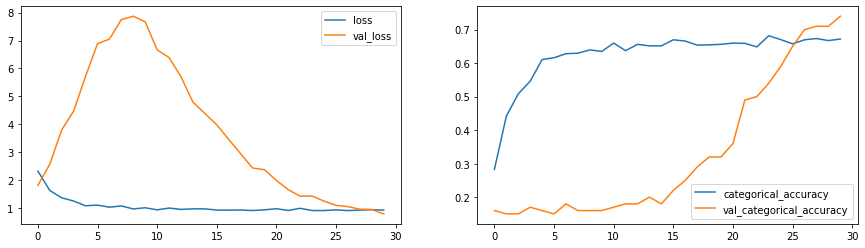

In [31]:
plot(history_model11)

# Type-6 Conv3D:

In [32]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Model 11-Conv3D: Adding more layers** 
- Data Augmentation
- (3,3,3) filter size
- 120X120 image resolution
- frames to sample-16
- batch size-20
- epochs-30
- dense neurons-256
- dropout-0.50


In [33]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)    

In [34]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 92s 3s/step - loss: 2.4264 - categorical_accuracy: 0.2460 - val_loss: 2.3436 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-02-1511_24_38.867805/model-00001-2.15649-0.31599-2.34357-0.21000.h5
Epoch 2/30
34/34 [==============================] - 89s 3s/step - loss: 1.6126 - categorical_accuracy: 0.4543 - val_loss: 3.3460 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_init_2021-02-1511_24_38.867805/model-00002-1.59470-0.45324-3.34596-0.17000.h5
Epoch 3/30
34/34 [==============================] - 89s 3s/step - loss: 1.4118 - categorical_accuracy: 0.5339 - val_loss: 4.1150 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2021-02-1511_24_38.867805/model-00003-1.42385-0.53092-4.11505-0.21000.h5
Epoch 4/30
34/34 [==============================] - 88s 3s/step - loss: 1.2773 - categorical_accuracy: 0.5684 - val_loss: 4.7233 - val_categoric

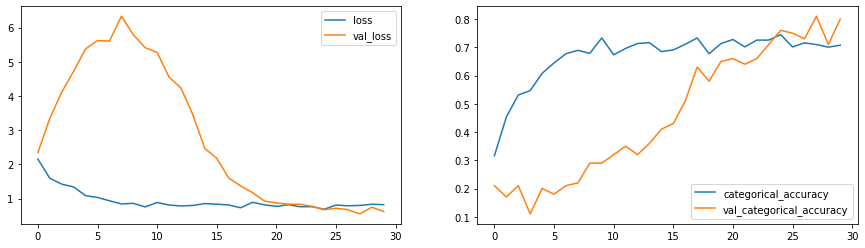

In [35]:
plot(history_model12)

# Type-7 Conv3D:

In [37]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Model 12-Conv3D: Adding Dropouts** 
- Data Augmentation
- (3,3,3) filter size
- 120X120 image resolution
- frames to sample-16
- batch size-20
- epochs-25
- dense neurons-256
- dropout-0.25


In [38]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 60, 60, 16)    

In [39]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 92s 3s/step - loss: 2.1658 - categorical_accuracy: 0.2372 - val_loss: 2.4423 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-1512_23_30.349824/model-00001-1.97744-0.30015-2.44234-0.16000.h5
Epoch 2/25
34/34 [==============================] - 88s 3s/step - loss: 1.5859 - categorical_accuracy: 0.4202 - val_loss: 3.7912 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_init_2021-02-1512_23_30.349824/model-00002-1.55553-0.41931-3.79119-0.17000.h5
Epoch 3/25
34/34 [==============================] - 95s 3s/step - loss: 1.3616 - categorical_accuracy: 0.4889 - val_loss: 5.2010 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2021-02-1512_23_30.349824/model-00003-1.39582-0.48341-5.20096-0.16000.h5
Epoch 4/25
34/34 [==============================] - 95s 3s/step - loss: 1.2073 - categorical_accuracy: 0.5460 - val_loss: 5.4385 - val_categoric

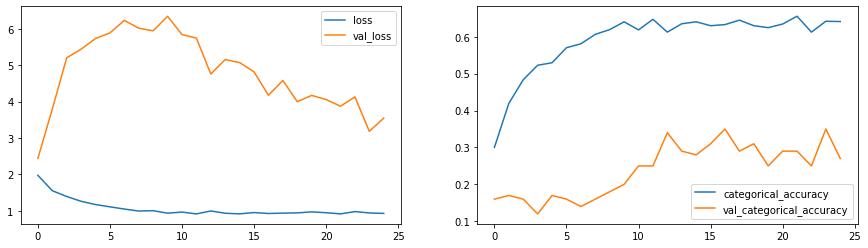

In [40]:
plot(history_model13)

# Type-8 Conv2D-LSTM with GRU:

In [41]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Model 13-Conv2D-LSTM with GRU:** 
- Data Augmentation
- 120X120 image resolution
- frames to sample-18
- batch size-20
- epochs-20
- dense neurons-128
- lstm-cells-128
- dropout-0.25


In [42]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 64)   

In [43]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - 102s 3s/step - loss: 1.6045 - categorical_accuracy: 0.3089 - val_loss: 1.6441 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2021-02-1513_18_44.176225/model-00001-1.47497-0.37707-1.64414-0.22000.h5
Epoch 2/20
34/34 [==============================] - 101s 3s/step - loss: 1.0536 - categorical_accuracy: 0.5816 - val_loss: 1.8834 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2021-02-1513_18_44.176225/model-00002-1.05127-0.58673-1.88342-0.22000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 0.8807 - categorical_accuracy: 0.6634 - val_loss: 2.2454 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-02-1513_18_44.176225/model-00003-0.83340-0.68854-2.24545-0.23000.h5
Epoch 4/20
34/34 [==============================] - 101s 3s/step - loss: 0.6819 - categorical_accuracy: 0.7491 - val_loss: 2.8426 - val_categ

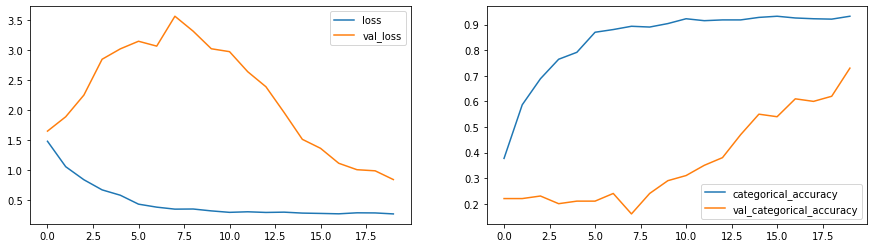

In [44]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Type-9 Transfer Learning with Mobilenet

In [46]:
from keras.applications import mobilenet

In [47]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 0s 0us/step


**Model 14-Transfer Learning using Mobilenet:** 
- Data Augmentation
- 120X120 image resolution
- frames to sample-16
- batch size-5
- epochs-20
- dense neurons-128
- lstm-cells-128
- dropout-0.25



In [48]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)              

In [49]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 96s 698ms/step - loss: 1.4609 - categorical_accuracy: 0.3689 - val_loss: 0.9251 - val_categorical_accuracy: 0.6700

Epoch 00001: saving model to model_init_2021-02-1514_09_35.410932/model-00001-1.32826-0.44268-0.92513-0.67000.h5
Epoch 2/20
133/133 [==============================] - 92s 693ms/step - loss: 0.8796 - categorical_accuracy: 0.6646 - val_loss: 0.7725 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2021-02-1514_09_35.410932/model-00002-0.86476-0.67345-0.77247-0.63000.h5
Epoch 3/20
133/133 [==============================] - 90s 682ms/step - loss: 0.6093 - categorical_accuracy: 0.7664 - val_loss: 0.6446 - val_categorical_accuracy: 0.7500

Epoch 00003: saving model to model_init_2021-02-1514_09_35.410932/model-00003-0.60525-0.76395-0.64461-0.75000.h5
Epoch 4/20
133/133 [==============================] - 89s 676ms/step - loss: 0.5034 - categorical_accuracy: 0.8277 - val_loss: 0.

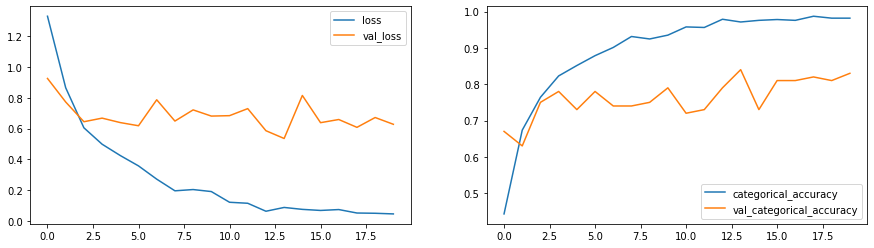

In [50]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Type-10 Transfer Learning with GRU and training all weights

In [11]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 0s 0us/step


**Model 15-Transfer Learning with GRU using all weights:** 
- Data Augmentation
- 120X120 image resolution
- frames to sample-16
- batch size-5
- epochs-20
- dense neurons-128
- gru-cells-128
- dropout-0.25



In [12]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               443136    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [13]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - 104s 700ms/step - loss: 1.4180 - categorical_accuracy: 0.4147 - val_loss: 0.6529 - val_categorical_accuracy: 0.7600

Epoch 00001: saving model to model_init_2021-02-1515_23_10.385604/model-00001-1.18090-0.52640-0.65290-0.76000.h5
Epoch 2/20
133/133 [==============================] - 90s 676ms/step - loss: 0.6051 - categorical_accuracy: 0.7474 - val_loss: 0.8455 - val_categorical_accuracy: 0.6800

Epoch 00002: saving model to model_init_2021-02-1515_23_10.385604/model-00002-0.62118-0.75490-0.84545-0.68000.h5
Epoch 3/20
133/133 [==============================] - 90s 680ms/step - loss: 0.5089 - categorical_accuracy: 0.8263 - val_loss: 0.2872 - val_categorical_accuracy: 0.8700

Epoch 00003: saving model to model_init_2021-02-1515_23_10.385604/model-00003-0.47282-0.83183-0.28724-0.87000.h5
Epoch 4/20
133/133 [==============================] - 89s 672ms/step - loss: 0.4135 - categorical_accuracy: 0.8444 - val_loss: 0

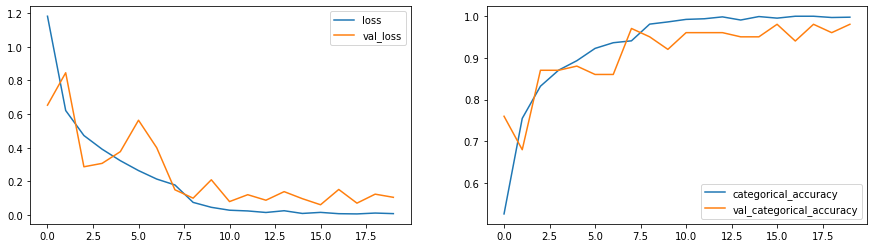

In [14]:
plot(history_model19)

# Loading model and Testing

In [15]:
import time
from keras.models import load_model
model = load_model('/content/model_init_2021-02-1515_23_10.385604/model-00020-0.00912-0.99698-0.10595-0.98000.h5')

**Testing Final Best Model using validation data:** 
- Data Augmentation
- 120X120 image resolution
- frames to sample-16
- batch size-5
- epochs-1

and predicting the labels



In [16]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)
g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)

In [17]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [18]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[1 3 1 0 0 1 3 1 0 0]
